Cosmology (compact) SS2020 

# Exercise sheet 3

## 3. The distribution of material within dark-matter haloes

In [1]:
#%matplotlib widget
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import matplotlib.colors as clr

In [2]:
# Read file, find the data, read the header
fname = "simulation"
f = h5py.File("/u/yali/cosmology/"+fname+".hdf5", 'r')
print(f["Snapshots"]["99"]["PartType1"].keys())

header = dict(f["Header"].attrs.items())
h = header["HubbleParam"]
mass_dm = header["MassTable"][1] * 1e10 / h
lbox = header["BoxSize"]/h

snapshot = 99
header_snapshot = dict(f["Snapshots/{}/Header".format(snapshot)].attrs.items())
z_snapshot = round(header_snapshot["Redshift"], 1)
a = header_snapshot["Time"]

<KeysViewHDF5 ['Coordinates', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Velocities']>


In [3]:
groupsdf = pd.DataFrame()
snapshot = 99
groupsdf["GroupPosX"] = f["Groups/{}/Group/GroupPos".format(snapshot)][:,0] * a/h
groupsdf["GroupPosY"] = f["Groups/{}/Group/GroupPos".format(snapshot)][:,1] * a/h
groupsdf["GroupPosZ"] = f["Groups/{}/Group/GroupPos".format(snapshot)][:,2] * a/h
groupsdf["M200c"] = f["Groups/{}/Group/Group_M_Crit200".format(snapshot)][:] * 1e10/h
groupsdf["R200c"] = f["Groups/{}/Group/Group_R_Crit200".format(snapshot)][:] * a/h
dmdf99 = pd.DataFrame()
dmdf99["DMPosX"] = f["Snapshots/{}/PartType1/Coordinates".format(snapshot)][:,0] * a/h
dmdf99["DMPosY"] = f["Snapshots/{}/PartType1/Coordinates".format(snapshot)][:,1] * a/h
dmdf99["DMPosZ"] = f["Snapshots/{}/PartType1/Coordinates".format(snapshot)][:,2] * a/h

Assuming the halo has a spherical shape, the 3D matter density profile can be determined by differential shells. 

The 3D matter density profile is calculated as follows: determine a R_min and R_max as well as number of bins to discretize the spherical shell. Using histogram the number of DM particles between two spherical shells is counted, and the range of each shell comes along. The number of DM particles times the mass of DM particle that's the mass of the spherical shell dM. dV is calculated as $dV = 4 \pi R^2  dR$. The density is thus $\rho = \frac{dM}{dV}$.

In [36]:
def profile3d(halo, n_bins):
    R_max = groupsdf["R200c"][halo]
    R_min = 0.03*R_max     
    x0 = groupsdf["GroupPosX"][halo]
    y0 = groupsdf["GroupPosY"][halo]
    z0 = groupsdf["GroupPosZ"][halo]
    x = dmdf99["DMPosX"]
    y = dmdf99["DMPosY"]
    z = dmdf99["DMPosZ"]
    # consider periodic boundary conditions
    if (x0 < R_max):
        x[x > (lbox - (R_max - x0))] -= lbox
    elif (lbox - x0 < R_max):
        x[x < (R_max - (lbox - x0))] += lbox
    if (y0 < R_max):
        y[y > (lbox - (R_max - y0))] -= lbox        
    elif (lbox - y0 < R_max):
        y[y < (R_max - (lbox - y0))] += lbox
    if (z0 < R_max):
        z[z > (lbox - (R_max - z0))] -= lbox    
    elif (lbox - z0 < R_max):
        z[z < (R_max - (lbox - z0))] += lbox
    r = np.sqrt((x-x0)**2+(y-y0)**2+(z-z0)**2)
    x = x[r < R_max][r > R_min]
    y = y[r < R_max][r > R_min]
    z = z[r < R_max][r > R_min]
    r = r[r < R_max][r > R_min]
    
    import matplotlib    
    fig = matplotlib.figure.Figure()
    ax = matplotlib.axes.Axes(fig, (0,0,0,0))
    hist = ax.hist(r, bins = n_bins, log = True)
    del ax, fig
    
    rho = hist[0]
    R_bins = hist[1]
    R = (R_bins[1:]+R_bins[:-1])/2
    for i in range(0, n_bins):
        rho[i] = mass_dm * rho[i] /(4*np.pi*(R[i])**2*(R_bins[i+1]- R_bins[i]))
    return R, rho, x, y, r 

Mass of the halo is 3.28E+13


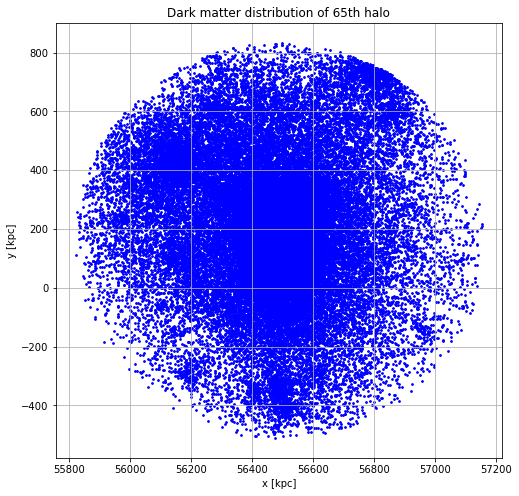

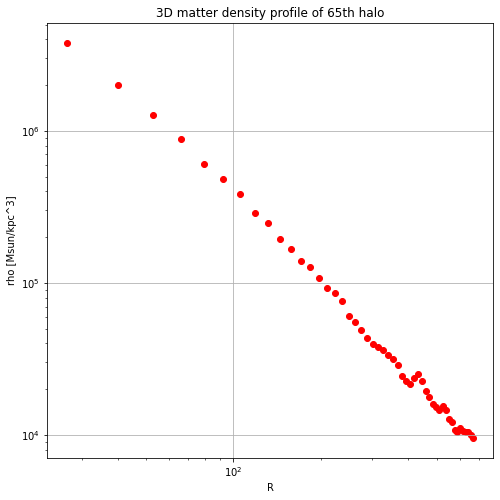

In [37]:
halo = 65
R, rho, x, y, r = profile3d(halo, 50)
print("Mass of the halo is %.2E"%(groupsdf["M200c"][halo]))
plt.figure(figsize=(8, 8))
plt.scatter(x, y, color = "b", s = 3)
plt.title("Dark matter distribution of 65th halo")
plt.xlabel("x [kpc]")
plt.ylabel("y [kpc]")
plt.grid()
plt.show()
plt.figure(figsize=(8, 8))
plt.scatter(R, rho, color = "r")
#plt.scatter(x, y, color = "r")
plt.title("3D matter density profile of 65th halo")
plt.xlabel("R")
plt.ylabel("rho [Msun/kpc^3]")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.show()

### Repeat this for many haloes in a few bins of halo mass.  

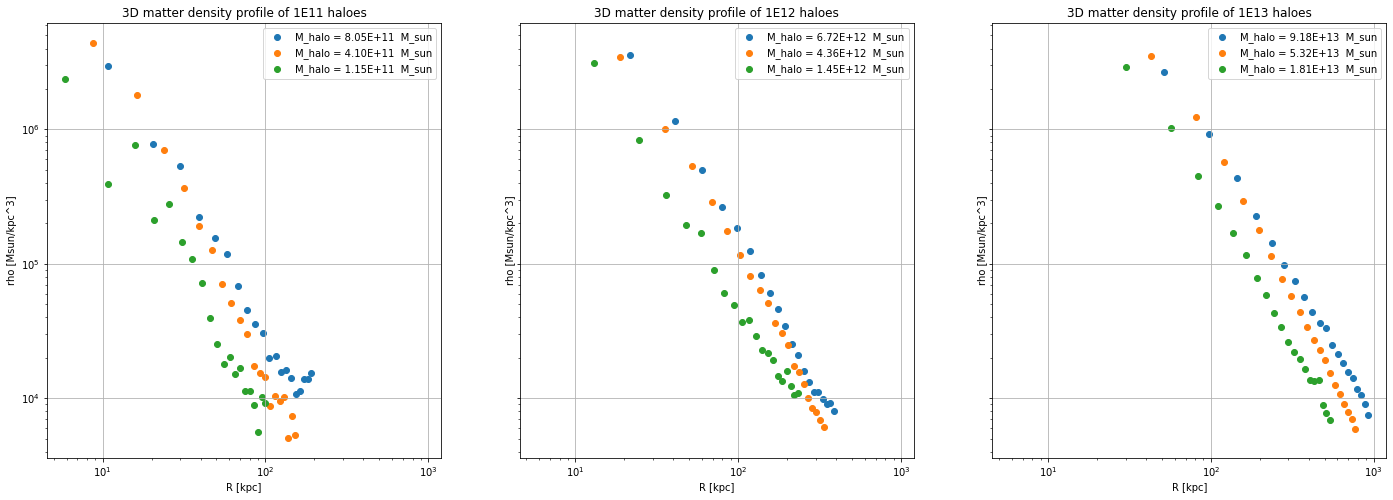

In [57]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, sharex=True, sharey = True, figsize=(24, 8))

for i in (2000, 5000, 15000): 
    R, rho, x, y, r  = profile3d(i, 20)
    axs[0].scatter(R, rho, label = "M_halo = %.2E  M_sun"%(groupsdf["M200c"][i]))
axs[0].set_title("3D matter density profile of 1E11 haloes")
    
for i in (300, 500, 1000): 
    R, rho, x, y, r  = profile3d(i, 20)
    axs[1].scatter(R, rho, label = "M_halo = %.2E  M_sun"%(groupsdf["M200c"][i]))
axs[1].set_title("3D matter density profile of 1E12 haloes")

for i in (20, 50, 80): 
    R, rho, x, y, r  = profile3d(i, 20)
    axs[2].scatter(R, rho, label = "M_halo = %.2E  M_sun"%(groupsdf["M200c"][i]))
axs[2].set_title("3D matter density profile of 1E13 haloes")

for ax in axs.flat:
    ax.set(xlabel='R [kpc]', ylabel='rho [Msun/kpc^3]', xscale = "log", yscale = "log")
    ax.grid()
    ax.legend()

plt.show()

The typical densities at the centers of the haloes are around 1e6 Msun/kpc^3. 

The innermost density do not depend much on the mass of the halo. The lighter the halo is, the smaller the radius it has, and the steeper its profile shows in the log-log plot. 

Now we normalize the profile and plot all of them in 1 figure. 

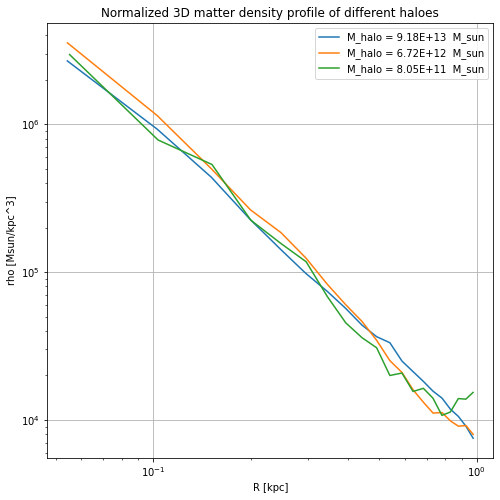

In [61]:
plt.figure(figsize=(8, 8))
for i in (20, 300, 2000):
    R, rho, x, y, r  = profile3d(i, 20)
    plt.plot(R/groupsdf["R200c"][i], rho, label = "M_halo = %.2E  M_sun"%(groupsdf["M200c"][i]))
plt.title("Normalized 3D matter density profile of different haloes")
plt.xlabel('R [kpc]')
plt.ylabel('rho [Msun/kpc^3]'),
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.legend()
plt.show()

From the normalized 3d matter density profile we see that there is almost no difference for haloes with masses in different order of magnitude.

### Fit with NFW profile

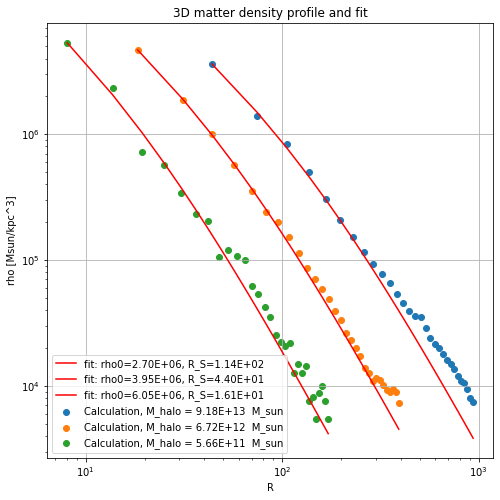

In [68]:
from scipy.optimize import curve_fit

def NFW(r, rho0, R_S):
    return rho0/((r/R_S)*(1+r/R_S)**2)

plt.figure(figsize=(8, 8))

for i in (20, 300, 3000):
    R, rho, x, y, r = profile3d(i, 30)
    popt, pcov = curve_fit(NFW, R, rho, p0 = (1e7, 1e2))
    plt.scatter(R, rho, label = "Calculation, M_halo = %.2E  M_sun"%(groupsdf["M200c"][i]))
    plt.plot(R, NFW(R, *popt), 'r-', label='fit: rho0=%.2E, R_S=%.2E' % tuple(popt))
plt.title("3D matter density profile and fit")
plt.xlabel("R")
plt.ylabel("rho [Msun/kpc^3]")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

Now we fit NFW profile for a large number of simulated haloes (random selected from Group catalog) and show the relation between the scale radius and halo mass. 

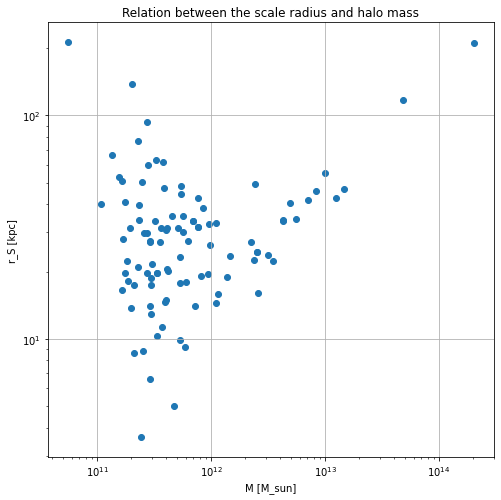

In [83]:
plt.figure(figsize=(8, 8))

r_S = []
M = []
for i in np.random.randint(0, 10000, 100):
    R, rho, x, y, r = profile3d(i, 30)
    popt, pcov = curve_fit(NFW, R, rho, p0 = (1e7, 1e2))
    r_S.append(popt[1])
    M.append(groupsdf["M200c"][i])
plt.scatter(M, r_S)
plt.title("Relation between the scale radius and halo mass")
plt.xlabel("M [M_sun]")
plt.ylabel("r_S [kpc]")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.show()

Based on the plot we see that the scale radius could be quite small for halo with lower mass. 